In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from keras.utils import to_categorical   
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
def create_dataset(dir_path: str) -> tuple:
    """
    Create a dataset from images in a directory.

    Args:
        dir_path (str): Path to the directory containing subdirectories with images.

    Returns:
        tuple: A tuple containing two arrays: (data, labels).
               The data array contains preprocessed image arrays, and the labels array contains the corresponding labels.
    """
    data, labels = [], []
    label = 0
    for subdir in os.listdir(dir_path):
        subdir_path = os.path.join(dir_path, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path):
                    # Load and preprocess the image
                    image = load_img(file_path, grayscale=False, color_mode='rgb', target_size=(40, 40))
                    image = img_to_array(image) / 255.0

                    # Append the preprocessed image array and corresponding label to the lists
                    data.append(image)
                    labels.append(label)

            label += 1

    # Convert the lists to NumPy arrays for improved efficiency
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [24]:
def predict_image(mapper_, model_, input_image_path, truth):
    # Load and preprocess a single image
    image = load_img(input_image_path, target_size=(40, 40))
    plt.imshow(image)
    image = img_to_array(image) / 255.0
    prediction_image = np.expand_dims(image, axis=0)

    # Make a single prediction
    prediction = model_.predict(prediction_image)
    predicted_class = np.argmax(prediction)
    predicted_move = mapper_[predicted_class]
    print(f"Prediction is {predicted_move} which is {predicted_move==truth}.")

In [2]:
# Set the path to the data directory.
train_dir = 'C:/Users/DhrCS/Documents/10_Kaggle/ASL_Dataset/Train'
test_dir = 'C:/Users/DhrCS/Documents/10_Kaggle/ASL_Dataset/Test'


In [5]:
# Load and preprocess the dataset, creating the data and label arrays.
data_train, labels0 = create_dataset(train_dir)
data_test, testlabels0 = create_dataset(test_dir)

# Modify the label into a one-hot encoded vector
labels=to_categorical(labels0)

# Split the dataset into training and test sets
train_x, test_x, train_y, test_y = train_test_split(data_train, labels, test_size=0.2, random_state=44)

# Initialize an ImageDataGenerator object with various data augmentation parameters
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest"
)

# Create the dataset generators
train_data = datagen.flow(train_x, train_y, batch_size=32)
test_data = datagen.flow(test_x, test_y, batch_size=32)

In [9]:
# Define the model architecture
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(40, 40, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Fine-tune the model by selectively unfreezing layers
for layer in pretrained_model.layers[:-10]:
    layer.trainable = False

# Build the classification head
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(28, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f"ASL_model_{timestamp}.h5")

# Print model summary
model.summary()

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

print("Starting model training...")
# Perform model training with mixed precision
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    epochs=15,
    callbacks=[early_stopping]
)
print("Model training completed.")

# Evaluate the model on test data
print("Evaluating the model on test data...")
test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 46, 46, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 20, 20, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 20, 20, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [10]:
# Perform predictions
y_pred = model.predict(test_x)
pred = np.argmax(y_pred, axis=1)
ground = np.argmax(test_y, axis=1)

# Print classification report
report = classification_report(ground, pred)
print("Classification Report:")
print(report)

1036/1036 [==============================] - 82s 75ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1222
           1       1.00      0.99      1.00      1201
           2       1.00      0.99      0.99      1189
           3       1.00      1.00      1.00      1200
           4       0.99      0.99      0.99      1220
           5       1.00      1.00      1.00      1199
           6       0.98      0.99      0.99      1169
           7       1.00      0.98      0.99      1167
           8       0.99      0.99      0.99      1183
           9       1.00      1.00      1.00      1216
          10       1.00      0.99      0.99      1211
          11       1.00      1.00      1.00      1155
          12       0.99      1.00      0.99      1211
          13       1.00      0.99      0.99      1257
          14       1.00      1.00      1.00      1195
          15       1.00      1.00      1.00      1156

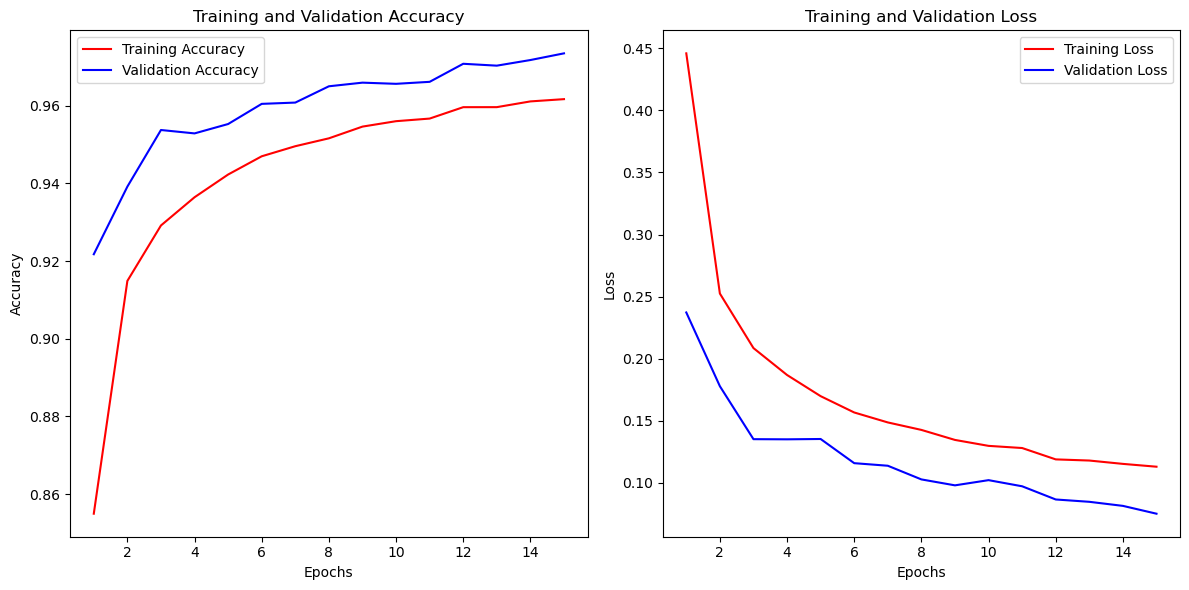

In [11]:
# Retrieve model history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Visualization of the comparison between training and validation on the accuracy as a function of the epochs
axs[0].plot(epochs, accuracy, 'r', label='Training Accuracy')
axs[0].plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Visualization of the comparison between training and validation on the loss as a function of the epochs
axs[1].plot(epochs, loss, 'r', label='Training Loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 80ms/step
Prediction is L which is True.
4/4 [==============================] - 0s 57ms/step
Accuracy: 100.00000%


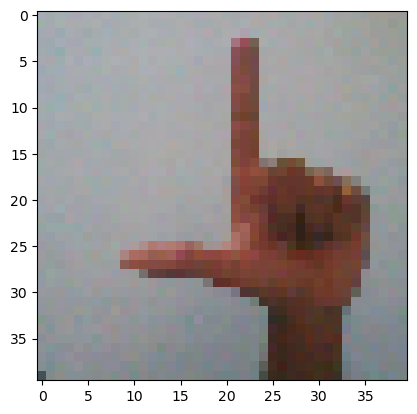

In [26]:
# Map position numbers with letters
mapper = {i: file for i, file in enumerate(os.listdir(train_dir))}

# Make a single prediction
truth = "L"
input_image_path = test_dir + "/" +truth +"/3001.jpg"
predict_image(mapper, model, input_image_path, truth)

# Perform predictions on the entire test dataset
test_predictions = model.predict(data_test)
predicted_classes = np.argmax(test_predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(testlabels0, predicted_classes)
print("Accuracy: {:.5%}".format(accuracy))

In [27]:
# Load saved model
loaded_model = load_model("ASL_model_20230617_185330.h5")

1/1 [==============================] - 3s 3s/step
Prediction is L which is True.


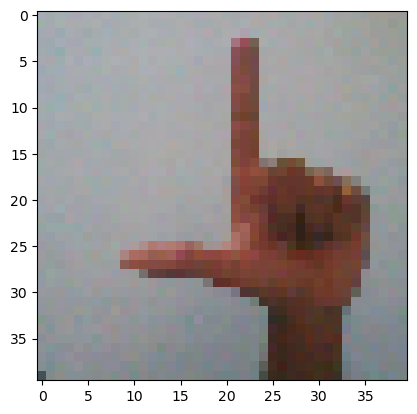

In [28]:
# Make a single prediction using loaded model
truth = "L"
input_image_path = test_dir + "/" +truth +"/3001.jpg"
predict_image(mapper, loaded_model, input_image_path, truth)